In [1]:
import collections
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping,ModelCheckpoint
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def read_data(data_path:str,encoding='utf8'):
    data = open(data_path,'r',encoding=encoding).read().replace('\u200b','').split('\n')
    while not data[-1]:
        del data[-1]
    return data
en_datas = read_data(r'data/small_vocab_en.txt')
fr_datas = read_data(r'data/small_vocab_fr.txt')
zhcn_datas = read_data(r'data/small_vocab_zhcn.txt')


print('英文数量:',len(en_datas))
print('法文数量:',len(fr_datas))
print('中文数量:',len(zhcn_datas))

英文数量: 137860
法文数量: 137860
中文数量: 137860


In [3]:
# 文字转id
def tokenize(x,char_level=False):
    x_tk = Tokenizer(char_level=char_level)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk
en_tokenized, en_tokenizer =tokenize(en_datas)
zhcn_tokenized, zhcn_tokenizer =tokenize(zhcn_datas,char_level=True)
# 填充长度
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen=length, padding='post')
preprocess_x = pad(en_tokenized)
preprocess_y = pad(zhcn_tokenized)[:,:,None]


In [4]:
def logits_to_text(logits, tokenizer):
    index_to_words = {_id:word for word,_id in tokenizer.word_index.items()}
    index_to_words[0]='<PAD>'
    return ''.join([index_to_words[index] for index in np.argmax(logits, 1)])
    

In [5]:
def translation_model(input_shape, output_sequence_length, english_vocab_size, zhcn_vocab_size):
    input_seq = Input((input_shape[1:]))
    x = Embedding(english_vocab_size,64)(input_seq)
    x = Bidirectional(GRU(64,dropout=0.2,return_sequences=False))(x)
    x = RepeatVector(output_sequence_length)(x)
    x = Bidirectional(GRU(128,dropout=0.2,return_sequences=True))(x)
    x = TimeDistributed(Dense(zhcn_vocab_size))(x)
    x = Activation('softmax')(x)
    model = Model(input_seq,x)
    lr = 0.03
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(lr,decay=0.01), 
                 metrics = ['accuracy'])
    return model
    
    
model = translation_model(preprocess_x.shape,preprocess_y.shape[1],len(en_tokenizer.word_index)+1,len(zhcn_tokenizer.word_index)+1)

mc = ModelCheckpoint(filepath=r'weight\ep{epoch:03d}val_loss{val_loss:.3f}val_acc{val_accuracy:.3f}.h5',save_best_only=True,save_weights_only=True,verbose=1)
es = EarlyStopping(patience=5,min_delta=0.001)
model.load_weights('weight\weights.h5')
# his = model.fit(preprocess_x, preprocess_y, 
#                 batch_size=64, epochs=500, 
#                 validation_split=0.2,
#                 callbacks=[mc,es])
# model.save_weights(r'weight\weights.h5')

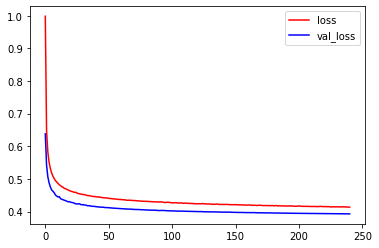

In [7]:
loss=his.history['loss']
val_loss=his.history['val_loss']
plt.plot(range(len(loss)),loss,color='red')
plt.plot(range(len(val_loss)),val_loss,color='blue')
plt.legend(labels=['loss','val_loss',])


In [8]:
ens = en_datas[:15]
zhcns = zhcn_datas[:15]
predicts = model.predict(preprocess_x[:15])
for en, zhcn,predict in zip(ens,zhcns,predicts):
    print('英文输入:',en)
#     print(zhcn)
    print('翻译结果:',logits_to_text(predict,zhcn_tokenizer))
    print()
    

英文输入: new jersey is sometimes quiet during autumn , and it is snowy in april .
翻译结果: 新泽西秋天有时安静，4月下雪。<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>

英文输入: the united states is usually chilly during july , and it is usually freezing in november .
翻译结果: 美国通常在7月寒冷，11111月冻结。<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>

英文输入: california is usually quiet during march , and it is usually hot in june .
翻译结果: 加利福尼亚通常在3月安静，6月通常炎热。<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>

英文输入: the united states is sometimes mild during june , and it is cold in september .
翻译结果: 美国六月有时温和，9月寒冷。<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>

英文输入: your least liked fruit is the grape , but my least liked is the apple .
翻译结果: 你最不喜欢的水果是葡萄，但我最不喜欢的是苹果。<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>

英文输入: his favorite fruit is 